# An example on using Deep Ensembles for 1D Regression Problem
## This notebook is based on the article "Simple and Scaleable Predictive Uncertainty Estimation" by B. Lakshminarayan (NeurIPS 2017).


In [70]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Toy Example

Following Hernandez-Lobato and Adams (2015) and Lakshminarayanan et al. (2017), we will setup the problem of estimating predictive variance and evaluate the performance of the proposed method using a one-dimensional toy regression dataset. 

This dataset consists of 20 examples sampled from $Y = X^3 + \epsilon$, where $X \sim Unif(-4,4)$ and $\epsilon \sim N(0, 9)$. 









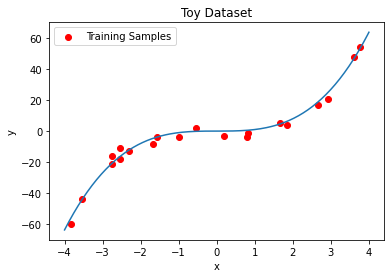

In [71]:
# setting the seed
np.random.seed(42)

# sample data
def draw_examples(n):
    x   = np.random.uniform(-4,4, n)
    eps = np.random.normal(0, 3, n)
    y   = np.power(x,3) + eps 
    return(x,y)

# getting x,y
toy_dataset    = draw_examples(20)
inputs, labels = toy_dataset

# Plot the data
xs = np.linspace(-4,4,200)
ys = np.power(xs,3)
plt.plot(xs,ys)
plt.scatter(toy_dataset[0],toy_dataset[1], color='r', label='Training Samples')
plt.legend(loc='best')
plt.ylabel("y")
plt.xlabel("x")
plt.title("Toy Dataset")
plt.show()

We follow the model architecture used in the Deep Ensemble article, which is:
1. A single layer with 100 hidden units and a ReLU activation function
2. ADAM optimizer with learning rate of 0.1
3. 40 epochs for training
4. 5 independently trained neural nets using ensembles
5. using adverserial training

## Deep Ensemble

### Step1: Network Setup
Creating the network involves three steps, these are:
1. Initializing the network
2. Defining the optimizer
3. Loss function

The Negative Log-Likelihood (NLL) criterion: 
$$ -logp_{\theta}(y_n \bigm| \mathbf{x}_n) = \frac{log(\sigma^2_{\theta}(\mathbf{x}))}{2} + \frac{(y - \mu_{\theta}(\mathbf{x}))^2}{2\sigma^2_{\theta}(\mathbf{x})} + \text{constant}$$ 

### Step 2: Adverserial Training
#### Key-points
Next, we add *adversarial* training to our training process. Adversarial training involves:
1. Modifying the training inputs slightly so as to be visually indistinguishable from the training examples but modified in such a way as to make the model worse at predicting their associated labels. 
2. Training using these adversarial examples makes the model more robust since it learns even more on points where it would perform badly. Additionally, adversarial training helps smooth the predictive distribution because it increases the likelihood of the model predicting the training value in an $\epsilon$ region around the training point. 
3. Generating adversarial examples involves moving the inputs approximately in the direction of steepest ascent. 

#### Procedure

In our particular case, we use the fast gradient sign method to create adversarial examples. This entails creating a new 
$$x’ = x + \epsilon\ \text{sign}(\nabla_x \ell(\theta, x,y))$$

Where $\epsilon = .01\ range(x)$ and evaluating $range(x)$ as the range of the training data along each dimension. We then train the model on both $x$ and $x’$ as two separate data points.

## Step 3: Ensembling

We combine all of the methods described above, and train 5 independent probabilistic neural nets using NLL criterion and adversarial training. Then, we combine their predictions as an ensemble. Since each neural net now has two outputs, we need a more nuanced method of combining the resulting predictions. This method is to set
$$ \mu_{*}(\mathbf{x}) = M^{-1}\sum_m\mu_{\theta_m}(\mathbf{x})$$
$$\sigma_{*}^2 = M^{-1}\sum_m(\sigma_{\theta_m}^2(\mathbf{x}) + \mu_{\theta_m}(\mathbf{x})) - \mu_{*}^2(\mathbf{x})$$

where M is the number of neural nets in the ensemble.

In [72]:
# Network Setup

class Net(nn.Module):
    def __init__(self, L):
        super(Net, self).__init__()
        self.l1 = nn.Linear(1, L)
        self.l2 = nn.Linear(L, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

# Negative log-likelihood scoring rule
nll_criterion = lambda mu, var, y: torch.log(var)/2 + ((y-mu)**2)/(2*var)
sp = torch.nn.Softplus()


In [73]:
# Create 5 neural nets with identical implementations
n = 5
nets_ops = []
for i in range(n):
    net = Net(100)
    optimizer = optim.Adam(net.parameters(), lr=0.1)
    nets_ops.append((net, optimizer))

print(nets_ops)

[(Net(
  (l1): Linear(in_features=1, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=2, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)), (Net(
  (l1): Linear(in_features=1, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=2, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)), (Net(
  (l1): Linear(in_features=1, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=2, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)), (Net(
  (l1): Linear(in_features=1, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=2, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)), (Net(
  (l1): L

In [74]:
# Train function
def train_model(net, optimizer):
    eps = .01*8
    alpha = .5
    running_loss = []
    for epoch in range(100):
        epoch_loss = 0
        for x, y in zip(inputs, labels):

            x = torch.tensor([x], dtype = torch.float, requires_grad=True)
            y = torch.tensor([y], dtype = torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = net(x)
            mu, sig = output[0], sp(output[1])+(10)**-6
            loss = nll_criterion(mu, sig, y)
            loss.backward(retain_graph=True)
            
            # adverserial training
            x_a = x + eps*(torch.sign(x.grad.data))
            optimizer.zero_grad()

            output_a = net(x_a)
            mu_a, sig_a = output_a[0], sp(output_a[1])+(10)**-6
            
            # compute total loss
            loss = nll_criterion(mu, sig, y) + nll_criterion(mu_a, sig_a, y)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()
        
        running_loss.append(epoch_loss/len(inputs))
    
    # plot loss vs epoch
    #plot_loss(running_loss)
    
    # predicted mean
    xs   = np.linspace(-6, 6, 100)
    mu_outputs = [net(torch.tensor([x],dtype = torch.float))[0] for x in xs]
    mu_outputs = np.hstack(torch.stack(mu_outputs).detach().numpy())
    
    # predicted variance
    sig_outputs = [net(torch.tensor([x],dtype = torch.float))[1] for x in xs]
    sig_outputs = np.hstack(torch.stack(sig_outputs).detach().numpy())
    return(running_loss, mu_outputs, sig_outputs)

In [75]:
# Generate predictions for each net
mus  = []
sigs = []

for net, op in nets_ops:
    loss, mu, sig = train_model(net, op)
    mus.append(mu)
    sigs.append(sig)

# Combine the outputs using the ensemble criteria
mus = np.vstack(mus)
print(mus)
mu_stars = np.mean(mus, axis = 0)
sigs = np.vstack(sigs)
print(sigs)

var_stars = np.mean(np.power(mus, 2) + sigs, axis = 0) - np.power(mu_stars, 2)
sig_3 = np.sqrt(var_stars)*3



[[-1.60432144e+02 -1.54532333e+02 -1.48628769e+02 -1.42725204e+02
  -1.36821701e+02 -1.30918335e+02 -1.25014984e+02 -1.19111603e+02
  -1.13216881e+02 -1.07325378e+02 -1.01433876e+02 -9.56201935e+01
  -9.00066299e+01 -8.44786530e+01 -7.89690552e+01 -7.34563293e+01
  -6.80409927e+01 -6.27831421e+01 -5.75339775e+01 -5.22922516e+01
  -4.70505142e+01 -4.18087959e+01 -3.65670662e+01 -3.13253422e+01
  -2.60836105e+01 -2.12668171e+01 -1.79098091e+01 -1.65529175e+01
  -1.51960249e+01 -1.38391333e+01 -1.24822378e+01 -1.11253481e+01
  -9.76845264e+00 -8.41156101e+00 -7.54537630e+00 -6.81799603e+00
  -6.09061575e+00 -5.39876461e+00 -4.71610975e+00 -4.03918934e+00
  -3.36039186e+00 -2.68167043e+00 -2.00294900e+00 -1.32422733e+00
  -6.50666177e-01 -4.00097013e-01 -4.99573231e-01 -6.99939370e-01
  -9.00305510e-01 -1.10067165e+00 -1.30103791e+00 -1.50140405e+00
  -1.70177031e+00 -1.86864769e+00 -1.89506173e+00 -1.71568465e+00
  -1.45941985e+00 -1.18399310e+00 -6.66619003e-01  2.98023462e-01
   1.31661

In [76]:
# Plot functions

def plot_point_results(toy, outputs):
    xs = np.linspace(-6,6,200)
    ys = np.power(xs,3)
    plt.plot(xs, outputs, color='g', label="Predictions")
    plt.scatter(toy[0],toy[1], color='r', label='Training Samples')
    plt.legend(loc='best')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ground Truth and Point Estimates")
    plt.plot(xs,ys)
    plt.show()

def plot_results(toy, outputs, output_variances):
    xs = np.linspace(-6,6,100)
    ys = np.power(xs,3)
    plt.scatter(toy[0],toy[1], color='r', label='Training Samples')
    plt.fill_between(xs, outputs+output_variances, outputs-output_variances, alpha=.5, label="3 $\sigma$ uncertainty envelope")
    plt.legend(loc='best')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ground Truth and Uncertainty Estimates")
    plt.plot(xs,ys)
    plt.show()

def plot_loss(loss):
    plt.plot(np.arange(len(loss)), loss)
    plt.show()

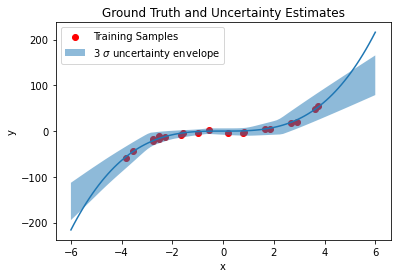

In [77]:
# Plot results

plot_results(toy_dataset, mu_stars, sig_3)

## Comparison with the results from the article

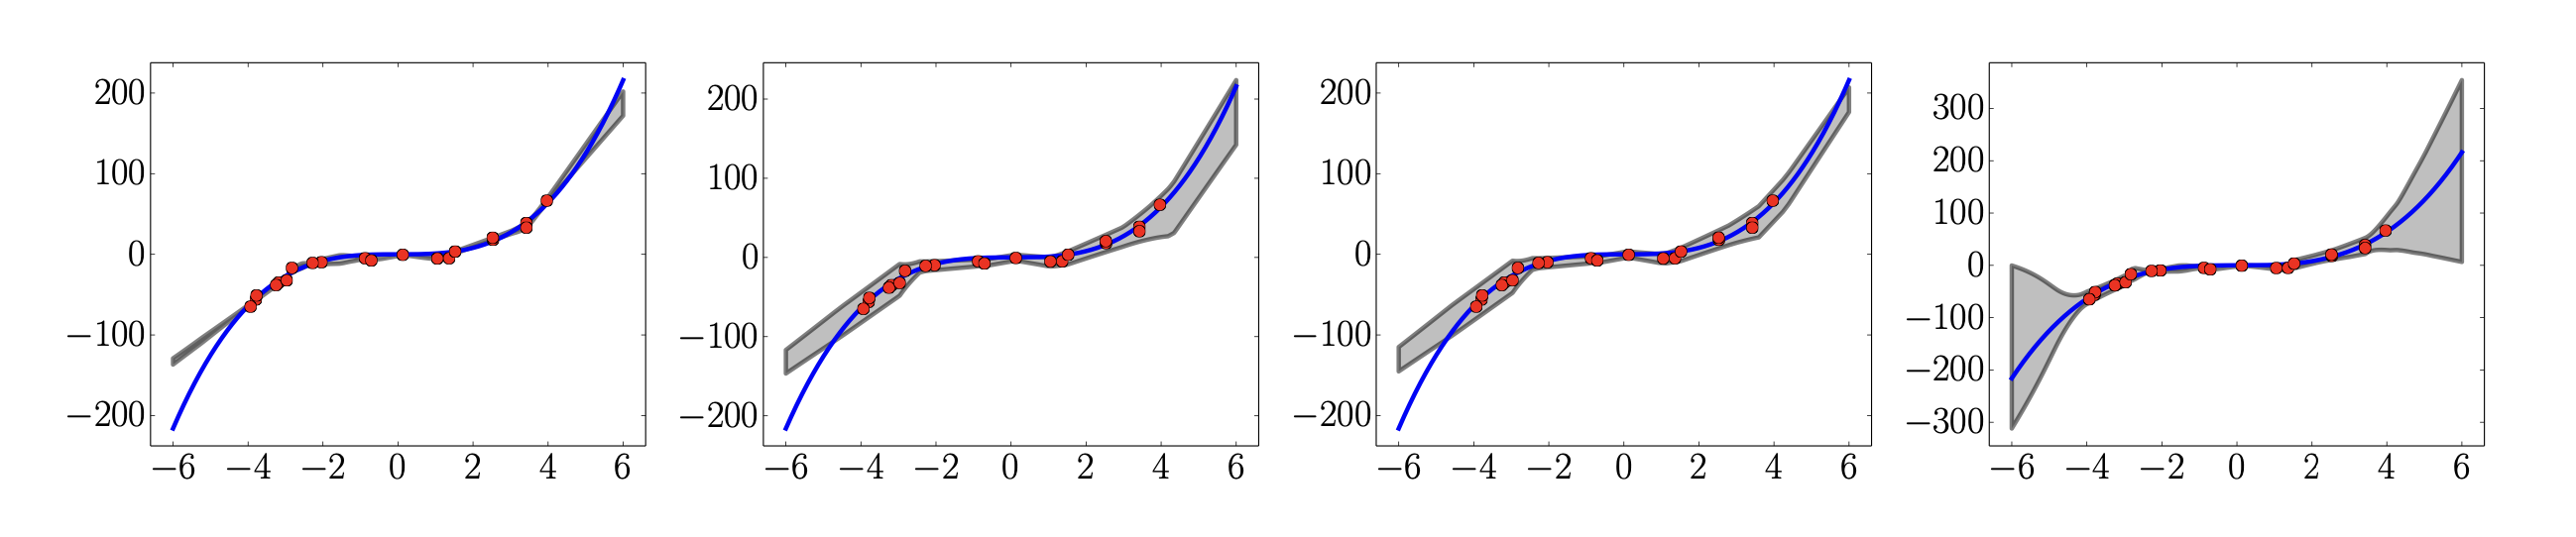

## Further Reading

Explaining and Harnessing Adverserial Examples : https://arxiv.org/pdf/1412.6572.pdf

Depth Uncertainty in Neural Networks (NeurIPS 2020): https://arxiv.org/pdf/2006.08437.pdf

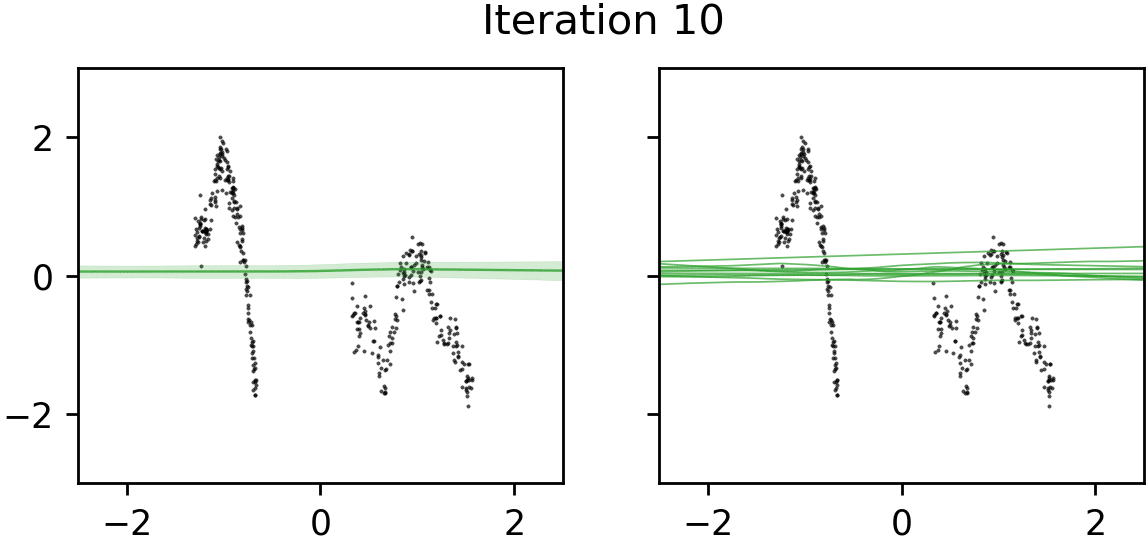

